# Data Preparation

In [132]:
from pandas import Series, DataFrame
import pandas as pd
import datetime as dt
import statsmodels.api as sm
from patsy import dmatrices
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [173]:
df = pd.read_csv('shot_logs.csv')
len(df)

128069

# Home Advantage Analysis

Home and Away team split

In [174]:
def data_split(x):
    (a,b)=x.split('-')
    a=a.strip()
    return a

def home_team_split(x):
    (a,b) = x.split('-')
    if '@' in b:
        (b1, b2) = b.split('@')
    if 'vs.' in b:
        (b2, b1) = b.split('vs.')
    b2 = b2.strip()
    return(b2)

def away_team_split(x):
    (a,b) = x.split('-')
    if '@' in b:
        (b2, b1) = b.split('@')
    if 'vs.' in b:
        (b1, b2) = b.split('vs.')
    b2 = b2.strip()
    return(b2)

def shooters_team(x):
    (a,b) = x.split('-')
    if '@' in b:
        (b1, b2) = b.split('@')
    if 'vs.' in b:
        (b1, b2) = b.split('vs.')
    b1 = b1.strip()
    return(b1)

def defenders_team(x):
    (a,b) = x.split('-')
    if '@' in b:
        (b1, b2) = b.split('@')
    if 'vs.' in b:
        (b1, b2) = b.split('vs.')
    b2 = b2.strip()
    return(b2)

def winners_team(x):
    if x['W']=='W':
        if x['players_team']==x['home_team']:
            return x['home_team']
        elif x['players_team']==x['away_team']:
            return x['away_team']
    else:
        if x['players_team']==x['home_team']:
            return x['away_team']
        elif x['players_team']==x['away_team']:
            return x['home_team']

df['date']=df['MATCHUP'].apply(data_split)
df['home_team']=df['MATCHUP'].apply(home_team_split)
df['away_team']=df['MATCHUP'].apply(away_team_split)
df['players_team']=df['MATCHUP'].apply(shooters_team)
df['defenders_team']=df['MATCHUP'].apply(defenders_team)
df['winners_team'] = df.apply(winners_team,axis=1)

df[:5]

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,FGM,PTS,player_name,player_id,date,home_team,away_team,players_team,defenders_team,winners_team
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,1,2,brian roberts,203148,"MAR 04, 2015",BKN,CHA,CHA,BKN,CHA
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,0,0,brian roberts,203148,"MAR 04, 2015",BKN,CHA,CHA,BKN,CHA
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,0,0,brian roberts,203148,"MAR 04, 2015",BKN,CHA,CHA,BKN,CHA
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,0,0,brian roberts,203148,"MAR 04, 2015",BKN,CHA,CHA,BKN,CHA
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,0,0,brian roberts,203148,"MAR 04, 2015",BKN,CHA,CHA,BKN,CHA


**Plot 1**: Proportion of total games split by Location win factor

Inference:

~56% of the games were won by Home teams. This gives us an initial direction to check for 'Home Team Advantage'.

Percentage of Away wins:  44.03 %
Percentage of Home wins:  55.97 %


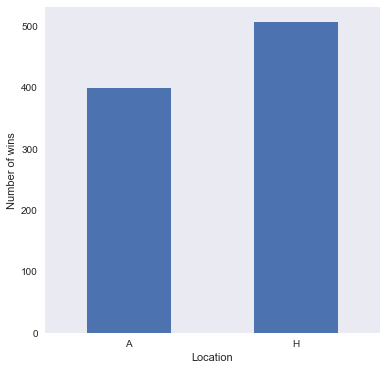

In [175]:
a = df[(df['SHOT_RESULT']=='made') & (df['W']=='W')].groupby('LOCATION')['GAME_ID'].nunique()
figure(figsize=(6,6))
plot_a = a.plot.bar(grid=False,rot=0)
plot_a.set_xlabel('Location')
plot_a.set_ylabel('Number of wins')
print 'Percentage of Away wins: ', round(float(a[0]*100)/(a[0]+a[1]),2),'%'
print 'Percentage of Home wins: ', round(float(a[1]*100)/(a[0]+a[1]),2),'%'

**Home - Away wins per team**

26 teams' have won more games at home than away, 
3 teams' have won more games away than at home, and 
1 team's home and away win ratios are almost equal

The analysis below shows that there is a clear evidence that a team playing at home is more likely to win with an average
win probability of 55.97%. The same conclusion is evident from the analysis conducted on a team level where 26
teams are winning more games at home than away. The results show that the NULL hypothesis should be rejected as
a team playing at home is more likely to win than an away team. 

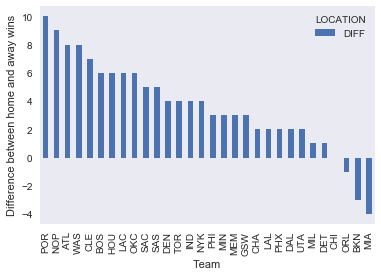

In [181]:
b= df[df['W']=='W'].groupby(['winners_team','LOCATION'])['GAME_ID'].nunique()
b = b.unstack('LOCATION')
b['DIFF'] = b['H'] - b['A']
b = b.sort_values(by='DIFF',ascending=False)
b = b[['DIFF']]

b=b.reset_index()
b = b.set_index('winners_team')
plot_homeadv = b.plot(kind='bar',grid=False)
figure(figsize=(20,10))
plot_homeadv.set_xlabel('Team')
plot_homeadv.set_ylabel('Difference between home and away wins')

Prepare for regression:

In [137]:
def bool_location(x):
    if x == "H":
        return 1 
    else:
        return 0

def bool_wins(x):
    if x == "W":
        return 1 
    else:
        return 0

df['LOCATION_BOOL'] = df['LOCATION'].apply(bool_location)
df['W_BOOL'] = df['W'].apply(bool_wins)

Linear regression analysis shows that playing at home gives teams on average additional 2.26 margin points.

The result of this research also confirms the recent trend of decline in home advantage over the years: probability of
a home team winning has reduced from around 65% in 1975-1992 to average of 60.3% in 1993-2011 and to around
58.5% for 2011-14. The analysis demonstrated that the home win ratio went down even further to 56.0% in 2014-
2015 season. 

Based on the literature review this trend could be potentially explained by the following factors(Economist, 2015):
 1. Improvement of travel conditions. This means that when playing away, teams are now more likely to stay at better hotels and fly chartered planes more often than in the past. These changes result in teams being less tired as a consequence of travel and being better physically prepared for the games.

 2. Change in style of play in NBA. The game now is more open with less physical contact, which reduces number of fouls and potential impact of 'notorious home-team bias' by referees (Economist, 2015).

Text(0.5,0,u'T-statistic of predictor')


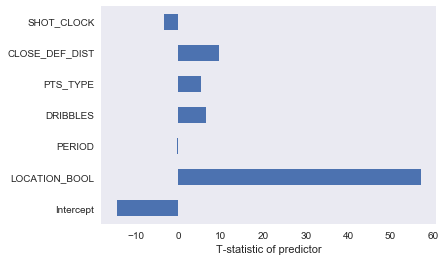

In [152]:
# REGRESSION OF ALL VARIABLES AGAINST FINAL MARGIN


model1 = sm.OLS(df['FINAL_MARGIN'], df['LOCATION_BOOL'])
result1 = model1.fit()
# print result1.summary()

#Plotting for first regresion
# scatter(x=df['LOCATION_BOOL'], y=df['FINAL_MARGIN'], label = 'Location vs Final Margin')

# sns.lmplot(x="SHOT_NUMBER", y="FINAL_MARGIN", hue="LOCATION", data=df);

y,X = dmatrices('FINAL_MARGIN ~ LOCATION_BOOL + PERIOD + DRIBBLES + PTS_TYPE + CLOSE_DEF_DIST + SHOT_CLOCK', data=df, return_type='dataframe')
model2 = sm.OLS(y,X)
result2 = model2.fit()
print result2.tvalues.plot.barh(grid=False).set_xlabel('T-statistic of predictor')

# Effect of rest on teams' performance

In [139]:
#Making date column
df['date'] = pd.to_datetime(df['date'])

df[:5]


,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,player_name,player_id,date,home_team,away_team,players_team,defenders_team,winners_team,LOCATION_BOOL,W_BOOL
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,brian roberts,203148,2015-03-04,BKN,CHA,CHA,BKN,CHA,0,1
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,brian roberts,203148,2015-03-04,BKN,CHA,CHA,BKN,CHA,0,1
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,brian roberts,203148,2015-03-04,BKN,CHA,CHA,BKN,CHA,0,1
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,brian roberts,203148,2015-03-04,BKN,CHA,CHA,BKN,CHA,0,1
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,brian roberts,203148,2015-03-04,BKN,CHA,CHA,BKN,CHA,0,1


In [140]:
#Create new dataframe with required columns
df_new = df[['GAME_ID','date','home_team','away_team','winners_team']].drop_duplicates()

df_rest_team = df_new.groupby('winners_team')['date'].apply(lambda x: x.sort_values())
df_rest_team = df_rest_team.to_frame()
df_rest_team = df_rest_team.rename(columns={0:'date'})
df_rest_team['diff'] = df_rest_team.groupby('winners_team')['date'].diff() / np.timedelta64(1, 'D')
df_rest_team['diff'] = df_rest_team['diff'].fillna(0)
diff_games = df_rest_team.groupby('diff')['date'].count()
diff_games = diff_games.to_frame()
pd.to_numeric(diff_games['date'])
diff_games['percentage of wins'] = 100*diff_games['date']/904
diff_games = diff_games.drop(diff_games.index[0])
diff_games[:5]

,date,percentage of wins
diff,,
1.0,103,11.393805
2.0,295,32.632743
3.0,146,16.150442
4.0,93,10.287611
5.0,54,5.973451


**Plot 1: Number of games vs Rest days** 

Most of the games are covered in the category where the rest days are 5 or less. Hence we shall deep dive into these games.

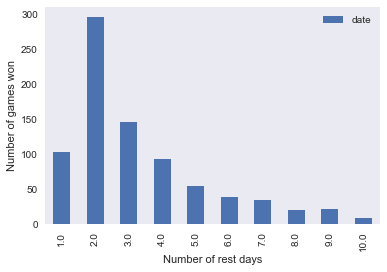

In [153]:
#PIE CHART: may not make sense- BUT KEEP CODE FOR REFERENCE

# import matplotlib.pyplot as plt
# plt.pie(d1['percentage of wins'],labels = d1.index)
# # View the plot drop above
# plt.axis('equal')

# # View the plot
# plt.tight_layout()
# plt.show()

#Bar plot

rest_plot = diff_games[:10].plot(y='date',kind='bar',grid=False)
rest_plot.set_ylabel('Number of games won')
rest_plot.set_xlabel('Number of rest days')

Calculating number of home games won vs number of rest days taken

In [142]:
mask_home_wins = df_new['winners_team'] == df_new['home_team']
df_home_wins = df_new[mask_home_wins][['home_team','GAME_ID','date']].drop_duplicates()
df_home_wins = df_home_wins.groupby('home_team')['date'].apply(lambda x: x.sort_values())
df_home_wins = df_home_wins.to_frame()
df_home_wins = df_home_wins.rename(columns={0:'date'})
df_home_wins['diff'] = df_home_wins.groupby('home_team')['date'].diff() / np.timedelta64(1, 'D')
df_home_wins['diff'] = df_home_wins['diff'].fillna(0)

diff_homewins = df_home_wins.groupby('diff')['date'].count()
diff_homewins = diff_homewins.to_frame()
pd.to_numeric(diff_homewins['date'])
diff_homewins['percentage of wins'] = (diff_homewins['date']*100)/(diff_homewins['date'].sum())
diff_homewins = diff_homewins.drop(diff_homewins.index[0])
# diff_homewins[:5]

Calculating number of away games won vs number of rest days

In [145]:
mask_away_wins = df_new['winners_team'] == df_new['away_team']
df_away_wins = df_new[mask_away_wins][['away_team','GAME_ID','date']].drop_duplicates()
df_away_wins = df_away_wins.groupby('away_team')['date'].apply(lambda x: x.sort_values())
df_away_wins = df_away_wins.to_frame()
df_away_wins = df_away_wins.rename(columns={0:'date'})
df_away_wins['diff'] = df_away_wins.groupby('away_team')['date'].diff() / np.timedelta64(1, 'D')
df_away_wins['diff'] = df_away_wins['diff'].fillna(0)

diff_awaywins = df_away_wins.groupby('diff')['date'].count()
diff_awaywins = diff_awaywins.to_frame()
pd.to_numeric(diff_awaywins['date'])
diff_awaywins['percentage of wins'] = (diff_awaywins['date']*100)/(diff_awaywins['date'].sum())
diff_awaywins = diff_awaywins.drop(diff_awaywins.index[0])
# diff_awaywins[:5]

**Plot 2: ** Shows number of rest days vs number of games won for Home and Away teams

Home teams' performance is better as they have more rest, but this is true upto 2 rest days. After this, rest starts to cost them.

Away teams' performance sees very little change on varying number of rest days.

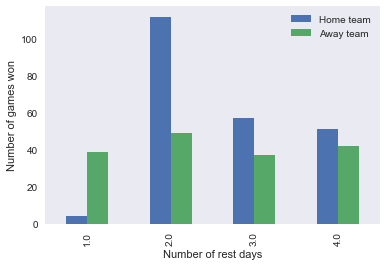

In [154]:
diff_home_away = diff_homewins.merge(diff_awaywins, left_index=True, right_index = True)
plot_homeaway = diff_home_away[['date_x','date_y']][:4].plot(kind='bar',grid=False)
plot_homeaway.set_xlabel('Number of rest days')
plot_homeaway.set_ylabel('Number of games won')
plot_homeaway.legend(["Home team", "Away team"])